In [1]:
import requests
import pandas as pd
import re
from bs4 import BeautifulSoup

url = "https://imslp.org/wiki/List_of_works_by_Johannes_Brahms"
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

In [2]:
table = soup.find("table")
table_text = []

for row in table.findAll("tr"):
    cells = row.findAll(["th", "td"])
    # Remove new line from each string in the process
    cell_contents = [cell.text.replace("\n", "") for cell in cells]
    table_text.append(cell_contents)
raw_works = pd.DataFrame(table_text[1:], columns = table_text[0])
raw_works.head()

,Opus,WoO,Title,Forces,Key,Date,Genre,Notes
0,,,Works with Opus Number,,,,,
1,Op.001,—,Piano Sonata No.1,pf,C major,1852–53,Keyboard,
2,Op.002,—,Piano Sonata No.2,pf,F♯ minor,1852,Keyboard,
3,Op.003,—,Songs (6),sop/ten pf,,1852–53,Vocal,
4,Op.003/1,—,"Liebestreu (""O versenk' versenk' dein Leid, m...",sop/ten pf,E♭ minor,1853,Vocal,


In [3]:
raw_works.tail()

,Opus,WoO,Title,Forces,Key,Date,Genre,Notes
991,—,Anh.4/6/5,Chant bohémien,pf4h,G major,1852?,Keyboard,arr. of the Bohemian folksong There's a Big V...
992,—,Anh.4/6/6,"Chant bohémien (""Коса"")",pf4h,G major,1852?,Keyboard,arr. of the Bohemian folksong The Plait
993,—,Anh.4/7,Cadenza,pf,C minor,—,WoO Keyboard,"for the Piano Concerto No.3, Op.37, by Ludwig..."
994,—,—,Album Leaf,pf,A minor,,Keyboard,
995,—,—,"Française, on favourite opera themes for Piano",pf,,1836,Keyboard,"published under the pseudonym ""G. W. Marks""; ..."


In [4]:
raw_works.shape

(996, 8)

In [5]:
df = raw_works.copy()
df.columns = [column.lower() for column in df.columns]

In [6]:
# ONLY consider compositions with Opus number
df = df[(df['opus'] != ' —') & (df['opus'] != '')]
df.head()

,opus,woo,title,forces,key,date,genre,notes
1,Op.001,—,Piano Sonata No.1,pf,C major,1852–53,Keyboard,
2,Op.002,—,Piano Sonata No.2,pf,F♯ minor,1852,Keyboard,
3,Op.003,—,Songs (6),sop/ten pf,,1852–53,Vocal,
4,Op.003/1,—,"Liebestreu (""O versenk' versenk' dein Leid, m...",sop/ten pf,E♭ minor,1853,Vocal,
5,Op.003/2,—,"Liebe und Frühling (""Wie sich Rebenranken"")",sop/ten pf,B major,"1853, rev.1882",Vocal,


In [7]:
if len(df[df["date"] == ""]) !=0:
    df = df[df["date"] != ""]

In [8]:
if len(df[df["key"] == ""]) != 0:
    df = df[df["key"] != ""]

In [9]:
df['key']= df['key'].str.strip()
sorted(df["key"].unique())

['A major',
 'A major–F minor',
 'A minor',
 'A minor–A major',
 'A minor–C major',
 'A♭ major',
 'A♭ minor–A♭ major',
 'B major',
 'B minor',
 'B minor–B major',
 'B♭ major',
 'B♭ minor',
 'C major',
 'C minor',
 'C minor–C major',
 'C♯ major',
 'C♯ minor',
 'C♯ minor–D♭ major',
 'D major',
 'D minor',
 'D minor–D major',
 'D ninor',
 'D♭ major',
 'E major',
 'E major–E minor',
 'E minor',
 'E minor–E major',
 'E♭ major',
 'E♭ minor',
 'F major',
 'F minor',
 'F minor–F major',
 'F♯ major',
 'F♯ minor',
 'F♯ minor–F♯ major',
 'G major',
 'G minor',
 'G minor–G major',
 'G♭ major',
 'G♯ minor']

In [10]:
def decide_key(key):
    if "major" in key:
        if "minor" not in key:
            return "major"
        else:
            return "other"
    elif "minor" in key:
        if "major" not in key:
            return "minor"
        else:
            return "other"
    else:
        return None
df["mode"] = df["key"].apply(decide_key)

In [11]:
df["date"].min(), df["date"].max()

(' 1851', '\xa0?')

In [12]:
df = df[~df["date"].str.contains("\?")]

In [13]:
df = df[df["date"].apply(lambda x: bool(re.search("[0-9]", x)))]
df["date"].min(), df["date"].max()

(' 1851', ' 1896')

In [14]:
df["date"] = df["date"].str.strip()

In [15]:
df["min_date"] = df["date"].apply(lambda x: x.split("–")[0] if "–" in x else x)
# Need to add the first two characters for second part of range
df["max_date"] = df["date"].apply(lambda x: x[0:2] + x.split("–")[1] if "–" in x else x)

In [16]:
df["min_date"]

1                1852
2                1852
4                1853
5      1853, rev.1882
6                1853
            ...      
664              1894
666              1896
667              1896
668              1896
669              1896
Name: min_date, Length: 321, dtype: object

In [17]:
df["max_date"]

1                1853
2                1852
4                1853
5      1853, rev.1882
6                1853
            ...      
664              1894
666              1896
667              1896
668              1896
669              1896
Name: max_date, Length: 321, dtype: object

In [18]:
df["max_date"] = df["max_date"].apply(lambda x: x.split(", rev.")[0] if ", rev." in x else x)
df["min_date"] = df["min_date"].apply(lambda x: x.split(", rev.")[0] if ", rev." in x else x)

In [19]:
df["max_date"] = df["max_date"].apply(int)
df["min_date"] = df["min_date"].apply(int)
df['ave_date'] = (df["max_date"] + df["min_date"]) / 2

In [20]:
df.reset_index(drop=True, inplace=True)
df.head()

,opus,woo,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
0,Op.001,—,Piano Sonata No.1,pf,C major,1852–53,Keyboard,,major,1852,1853,1852.5
1,Op.002,—,Piano Sonata No.2,pf,F♯ minor,1852,Keyboard,,minor,1852,1852,1852.0
2,Op.003/1,—,"Liebestreu (""O versenk' versenk' dein Leid, m...",sop/ten pf,E♭ minor,1853,Vocal,,minor,1853,1853,1853.0
3,Op.003/2,—,"Liebe und Frühling (""Wie sich Rebenranken"")",sop/ten pf,B major,"1853, rev.1882",Vocal,,major,1853,1853,1853.0
4,Op.003/3,—,"Liebe und Frühling (""Ich muss hinaus, ich mus...",sop/ten pf,B major,1853,Vocal,,major,1853,1853,1853.0


In [21]:
df.tail()

,opus,woo,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
316,Op.120/2,—,Sonata No.2,cl/va pf,E♭ major,1894,Chamber,,major,1894,1894,1894.0
317,Op.121/1,—,Denn es gehet dem Menschen,bass pf,D minor,1896,Vocal,,minor,1896,1896,1896.0
318,Op.121/2,—,Ich wandte mich und sahe an alle,bass pf,G minor–G major,1896,Vocal,,other,1896,1896,1896.0
319,Op.121/3,—,"O Tod, wie bitter bist du",bass pf,E minor–E major,1896,Vocal,,other,1896,1896,1896.0
320,Op.121/4,—,Wenn ich mit Menschen- und mit Engelszungen r...,bass pf,E♭ major,1896,Vocal,,major,1896,1896,1896.0


In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

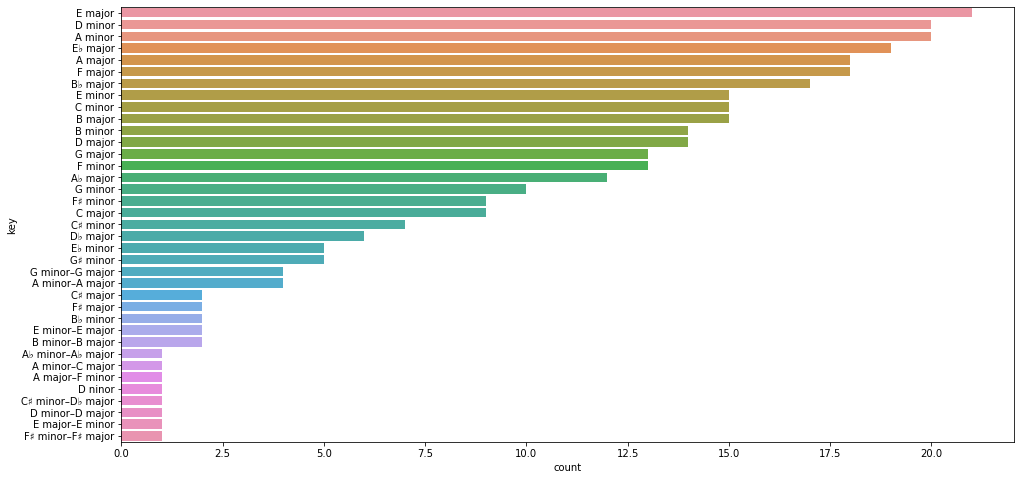

In [23]:
plt.figure(figsize=(16,8))
sns.countplot(y=df['key'], data=df, order = df['key'].value_counts().index)
plt.savefig("brahms-key.jpg")

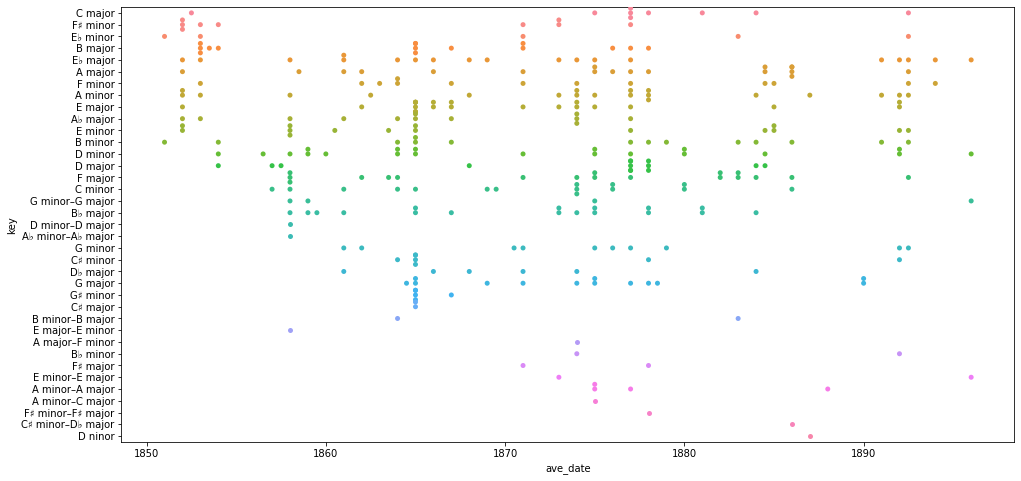

In [35]:
plt.figure(figsize=(16,8))
sns.swarmplot(x=df['ave_date'],y=df['key'])

In [24]:
df.loc[df['key'] == 'E major']

,opus,woo,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
11,Op.006/2,—,"Der Frühling (""Es lockt und säuselt um den Ba...",sop/ten pf,E major,1852,Vocal,,major,1852,1852,1852.0
73,Op.033/13,—,"Sulima (""Geliebter, wo zaudert dein irrender ...",v pf,E major,1862,Vocal,,major,1862,1862,1862.0
85,Op.039/02,—,Waltz No.02,pf4h,E major,1865,Keyboard,also arr. for pf and for 2pf,major,1865,1865,1865.0
86,Op.039/02,—,Waltz No.02,pf,E major,1865,Keyboard,arr. of the version for pf4h,major,1865,1865,1865.0
87,Op.039/02,—,Waltz No.02,2pf,E major,1867,Keyboard,arr. of the version for pf4h,major,1867,1867,1867.0
92,Op.039/05,—,Waltz No.05,pf4h,E major,1865,Keyboard,also arr. for pf,major,1865,1865,1865.0
93,Op.039/05,—,Waltz No.05,pf,E major,1865,Keyboard,arr. of the version for pf4h,major,1865,1865,1865.0
108,Op.039/12,—,Waltz No.12,pf4h,E major,1865,Keyboard,also arr. for pf,major,1865,1865,1865.0
109,Op.039/12,—,Waltz No.12,pf,E major,1865,Keyboard,arr. of the version for pf4h,major,1865,1865,1865.0
127,Op.046/3,—,"Die Schale der Vergessenheit (""Eine Schale de...",v pf,E major,1864–68,Vocal,,major,1864,1868,1866.0


In [25]:
df.loc[df["key"] == "D minor"]

,opus,woo,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
24,Op.010/1,—,"Ballade No.1 (""Edward"")",pf,D minor,1854,Keyboard,,minor,1854,1854,1854.0
39,Op.015,—,Piano Concerto No.1,pf orch,D minor,1854–59,Orchestral,also arr. for 2pf and for pf4h,minor,1854,1859,1856.5
40,Op.015,—,Piano Concerto No.1,2pf,D minor,1859,Keyboard,arr. of version for pf orch,minor,1859,1859,1859.0
41,Op.015,—,Piano Concerto No.1,pf4h,D minor,1859,Keyboard,arr. of version for pf orch,minor,1859,1859,1859.0
45,Op.018b,—,Theme and Variations,pf,D minor,1860,Keyboard,arr. of the 2nd movt. from Op.18,minor,1860,1860,1860.0
47,Op.019/2,—,"Scheiden und Meiden (""So soll ich dich nun me...",v pf,D minor,1858,Vocal,,minor,1858,1858,1858.0
58,Op.032/2,—,Nicht mehr zu dir zu gehen,v pf,D minor,1864,Vocal,,minor,1864,1864,1864.0
59,Op.032/3,—,Ich schleich umher betrübt und stumm,v pf,D minor,1864,Vocal,,minor,1864,1864,1864.0
101,Op.039/09,—,Waltz No.09,pf4h,D minor,1865,Keyboard,also arr. for pf,minor,1865,1865,1865.0
102,Op.039/09,—,Waltz No.09,pf,D minor,1865,Keyboard,arr. of the version for pf4h,minor,1865,1865,1865.0


In [26]:
df.loc[df['key'] == 'A minor']

,opus,woo,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
10,Op.006/1,—,"Spanisches Lied (""In dem Schatten meiner Lock...",sop/ten pf,A minor,1852,Vocal,,minor,1852,1852,1852.0
18,Op.007/3,—,"Anklänge (""Hoch über stillen Höhen"")",v pf,A minor,1853,Vocal,,minor,1853,1853,1853.0
20,Op.007/5,—,"Die Trauernde (""Mei Mueter mag mi net"")",v pf,A minor,1852,Vocal,,minor,1852,1852,1852.0
32,Op.014/2,—,"Vom verwundeten Knaben (""Es vollt ein Mädchen...",v pf,A minor,1858,Vocal,,minor,1858,1858,1858.0
79,Op.035,—,Variations on a Theme by Paganini,pf,A minor,1862–63,Keyboard,,minor,1862,1863,1862.5
140,Op.052a/02,—,Liebeslieder Waltz No.02,pf,A minor,1874,Keyboard,arr. of Op.52/2,minor,1874,1874,1874.0
143,Op.052a/05,—,Liebeslieder Waltz No.05,pf,A minor,1874,Keyboard,arr. of Op.52/5,minor,1874,1874,1874.0
171,Op.058/8,—,"Serenade (""Leise um dich nicht zu wecken"")",v pf,A minor,"1868, rev.1871",Vocal,,minor,1868,1868,1868.0
176,Op.059/6,—,"Eine gute, gute Nacht",v pf,A minor,1873,Vocal,,minor,1873,1873,1873.0
180,Op.065a/01,—,Neue Liebeslieder Waltz No.01,pf4h,A minor,1875,Keyboard,arr. of Op.65/1,minor,1875,1875,1875.0


In [27]:
df['genre'] = df['genre'].str.strip()

In [28]:
df['genre'].unique()

array(['Keyboard', 'Vocal', 'Chamber', 'Orchestral'], dtype=object)

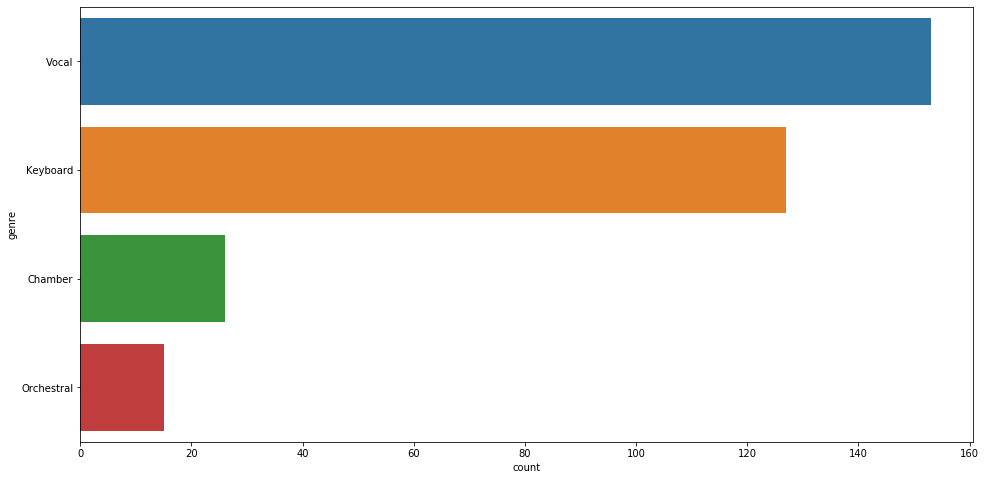

In [29]:
plt.figure(figsize=(16,8))
sns.countplot(y=df['genre'], data=df, order=df['genre'].value_counts().index)

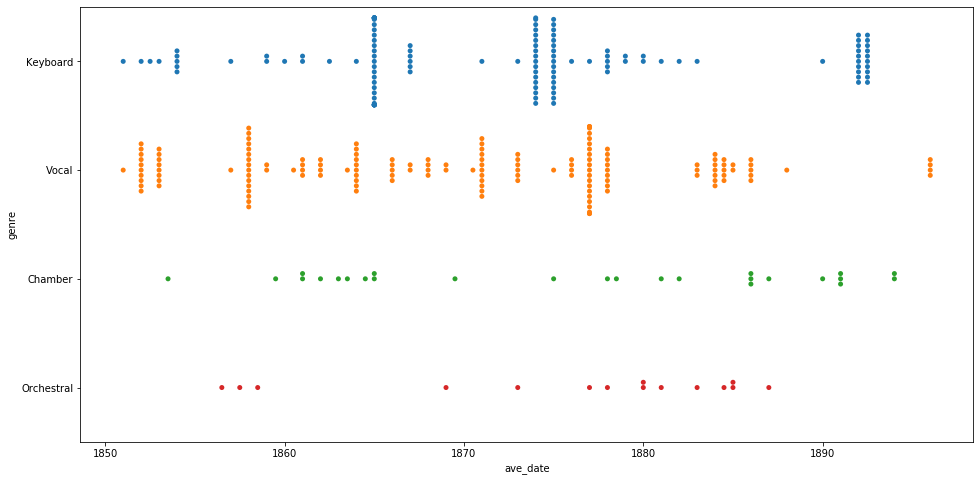

In [30]:
plt.figure(figsize=(16,8))
sns.swarmplot(x=df['ave_date'],y=df['genre'])

In [31]:
df.loc[df['title'].str.contains('Piano', case=False)]

,opus,woo,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
0,Op.001,—,Piano Sonata No.1,pf,C major,1852–53,Keyboard,,major,1852,1853,1852.5
1,Op.002,—,Piano Sonata No.2,pf,F♯ minor,1852,Keyboard,,minor,1852,1852,1852.0
9,Op.005,—,Piano Sonata No.3,pf,F minor,1853,Keyboard,,minor,1853,1853,1853.0
22,Op.008,—,Piano Trio No.1,vn pf vc,B major,"1853–54, rev.1889",Chamber,,major,1853,1854,1853.5
39,Op.015,—,Piano Concerto No.1,pf orch,D minor,1854–59,Orchestral,also arr. for 2pf and for pf4h,minor,1854,1859,1856.5
40,Op.015,—,Piano Concerto No.1,2pf,D minor,1859,Keyboard,arr. of version for pf orch,minor,1859,1859,1859.0
41,Op.015,—,Piano Concerto No.1,pf4h,D minor,1859,Keyboard,arr. of version for pf orch,minor,1859,1859,1859.0
54,Op.025,—,Piano Quartet No.1,vn va vc pf,G minor,1861,Chamber,also arr. for pf4h,minor,1861,1861,1861.0
55,Op.026,—,Piano Quartet No.2,vn va vc pf,A major,1861,Chamber,also arr. for pf4h,major,1861,1861,1861.0
77,Op.034,—,Piano Quintet,2vn va vc pf,F minor,1862–64,Chamber,2nd version of String Quintet (1862); also a...,minor,1862,1864,1863.0


In [32]:
df.loc[df['title'].str.contains('String Quartet', case=False)]

,opus,woo,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
138,Op.051/1,—,String Quartet No.1,2vn va vc,C minor,1866–73,Chamber,also arr. for pf4h,minor,1866,1873,1869.5
195,Op.067,—,String Quartet No.3,2vn va vc,B♭ major,1875,Chamber,also arr. for pf4h,major,1875,1875,1875.0
196,Op.067,—,String Quartet No.3,pf4h,B♭ major,1875,Keyboard,arr. of the version for 2vn va vc,major,1875,1875,1875.0


In [33]:
df.loc[df['title'].str.contains('Sonata', case=False)]

,opus,woo,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
0,Op.001,—,Piano Sonata No.1,pf,C major,1852–53,Keyboard,,major,1852,1853,1852.5
1,Op.002,—,Piano Sonata No.2,pf,F♯ minor,1852,Keyboard,,minor,1852,1852,1852.0
9,Op.005,—,Piano Sonata No.3,pf,F minor,1853,Keyboard,,minor,1853,1853,1853.0
78,Op.034b,—,Sonata,2pf,F minor,1864,Keyboard,2nd version of Op.34,minor,1864,1864,1864.0
81,Op.038,—,Cello Sonata No.1,vc pf,E minor,1862–65,Chamber,,minor,1862,1865,1863.5
236,Op.078,—,"Violin Sonata No.1 (""Regen"")",vn pf,G major,1878–79,Chamber,,major,1878,1879,1878.5
278,Op.099,—,Cello Sonata No.2,vc pf,F major,1886,Chamber,,major,1886,1886,1886.0
279,Op.100,—,"Violin Sonata No.2 (""Thun"")",vn pf,A major,1886,Chamber,,major,1886,1886,1886.0
290,Op.108,—,Violin Sonata No.3,vn pf,D ninor,1886–88,Chamber,,None,1886,1888,1887.0
315,Op.120/1,—,Clarinet Sonata No.1,cl/va pf,F minor,1894,Chamber,,minor,1894,1894,1894.0


In [34]:
df.loc[df['title'].str.contains('Symphony', case=False)]

,opus,woo,title,forces,key,date,genre,notes,mode,min_date,max_date,ave_date
197,Op.068,—,Symphony No.1,orch,C minor,1862–76,Orchestral,also arr. for pf4h,minor,1862,1876,1869.0
198,Op.068,—,Symphony No.1,pf4h,C minor,1876,Keyboard,arr. of the version for orch,minor,1876,1876,1876.0
222,Op.073,—,Symphony No.2,orch,D major,1877,Orchestral,also arr. for pf4h,major,1877,1877,1877.0
223,Op.073,—,Symphony No.2,pf4h,D major,1877,Keyboard,arr. of the version for orch,major,1877,1877,1877.0
257,Op.090,—,Symphony No.3,orch,F major,1883,Orchestral,also arr. for 2pf,major,1883,1883,1883.0
258,Op.090,—,Symphony No.3,2pf,F major,1883,Keyboard,arr. of the version for orch,major,1883,1883,1883.0
275,Op.098,—,Symphony No.4,orch,E minor,1884–85,Orchestral,also arr. for 2pf and for pf4h,minor,1884,1885,1884.5
276,Op.098,—,Symphony No.4,2pf,E minor,1885,Orchestral,arr. of the version for orch,minor,1885,1885,1885.0
277,Op.098,—,Symphony No.4,pf4h,E minor,1885,Orchestral,arr. of the version for orch,minor,1885,1885,1885.0
